<a href="https://colab.research.google.com/github/joshualin24/VAE-CVAE-MNIST/blob/master/CVAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import datetime

def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot


class VAE(nn.Module):

    def __init__(self, encoder_layer_sizes, latent_size, decoder_layer_sizes,
                 conditional=False, num_labels=0):

        super().__init__()

        if conditional:
            assert num_labels > 0

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list

        self.latent_size = latent_size

        self.encoder = Encoder(
            encoder_layer_sizes, latent_size, conditional, num_labels)
        self.decoder = Decoder(
            decoder_layer_sizes, latent_size, conditional, num_labels)

    def forward(self, x, c=None):

        if x.dim() > 2:
            x = x.view(-1, 28*28)

        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z, c)

        return recon_x, means, log_var, z

    def reparameterize(self, mu, log_var):

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def inference(self, z, c=None):

        recon_x = self.decoder(z, c)

        return recon_x


class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.conditional = conditional
        if self.conditional:
            layer_sizes[0] += num_labels

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())

        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, c=None):

        if self.conditional:
            c = idx2onehot(c, n=10)
            x = torch.cat((x, c), dim=-1)

        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)

        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional, num_labels):

        super().__init__()

        self.MLP = nn.Sequential()

        self.conditional = conditional
        if self.conditional:
            input_size = latent_size + num_labels
        else:
            input_size = latent_size

        for i, (in_size, out_size) in enumerate(zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
            else:
                self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z, c):

        if self.conditional:
            #print("info", z, c)
            c = idx2onehot(c, n=10)
            z = torch.cat((z, c), dim=-1)

            #print("info", z, c)

        x = self.MLP(z)

        return x

In [ ]:

def main(batch_size = 64, latent_size = 2, conditional = True, fig_root = './', epochs = 10):

    # torch.manual_seed(args.seed)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed(args.seed)

    best_loss = float('inf')

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ts = time.time()

    dataset = MNIST(
        root='data', train=True, transform=transforms.ToTensor(),
        download=True)
    data_loader = DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True)

    def loss_fn(recon_x, x, mean, log_var):
        BCE = torch.nn.functional.binary_cross_entropy(
            recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

        return (BCE + KLD) / x.size(0)

    vae = VAE(
        encoder_layer_sizes=[784, 256],
        latent_size=latent_size,
        decoder_layer_sizes=[256, 784],
        conditional=True,
        num_labels=10 if conditional else 0).to(device)

    optimizer = torch.optim.Adam(vae.parameters(), lr=1 * 10**-3)

    logs = defaultdict(list)

    for epoch in range(epochs):

        tracker_epoch = defaultdict(lambda: defaultdict(dict))

        for iteration, (x, y) in enumerate(data_loader):

            x, y = x.to(device), y.to(device)

            if conditional:
                recon_x, mean, log_var, z = vae(x, y)
            else:
                recon_x, mean, log_var, z = vae(x)

            for i, yi in enumerate(y):
                id = len(tracker_epoch)
                tracker_epoch[id]['x'] = z[i, 0].item()
                tracker_epoch[id]['y'] = z[i, 1].item()
                tracker_epoch[id]['label'] = yi.item()

            loss = loss_fn(recon_x, x, mean, log_var)

            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            

            logs['loss'].append(loss.item())

            if iteration % 800 == 0 or iteration == len(data_loader)-1:
                print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                    epoch, epochs, iteration, len(data_loader)-1, loss.item()))

                if conditional:
                    c = torch.arange(0, 10).long().unsqueeze(1).to(device)
                    z = torch.randn([c.size(0), latent_size]).to(device)
                    x = vae.inference(z, c=c)
                else:
                    z = torch.randn([10, latent_size]).to(device)
                    x = vae.inference(z)

                plt.figure()
                plt.figure(figsize=(5, 10))
                for p in range(10):
                    plt.subplot(5, 2, p+1)
                    if conditional:
                        plt.text(
                            0, 0, "c={:d}".format(c[p].item()), color='black',
                            backgroundcolor='white', fontsize=8)
                    plt.imshow(x[p].view(28, 28).cpu().data.numpy())
                    plt.axis('off')

                if not os.path.exists(os.path.join(fig_root, str(ts))):
                    if not(os.path.exists(os.path.join(fig_root))):
                        os.mkdir(os.path.join(fig_root))
                    os.mkdir(os.path.join(fig_root, str(ts)))

                plt.savefig(
                    os.path.join(fig_root, str(ts),
                                 "E{:d}I{:d}.png".format(epoch, iteration)),
                    dpi=300)
                plt.clf()
                plt.close('all')

        df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
        g = sns.lmplot(
            x='x', y='y', hue='label', data=df.groupby('label').head(100),
            fit_reg=False, legend=True)
        g.savefig(os.path.join(
            './', str(ts), "E{:d}-Dist.png".format(epoch)),
            dpi=300)
        if loss < best_loss:
            best_loss = loss
            datetime_today = str(datetime.date.today())
            torch.save(vae, './' + datetime_today +'vae.mdl')
            print("saved to " + "vae.mdl" + " file.")
        
        




Epoch 00/10 Batch 0000/937, Loss  544.6300
Epoch 00/10 Batch 0800/937, Loss  148.8442
Epoch 00/10 Batch 0937/937, Loss  146.1982
saved to vae.mdl file.
Epoch 01/10 Batch 0000/937, Loss  144.3576
Epoch 01/10 Batch 0800/937, Loss  147.5124
Epoch 01/10 Batch 0937/937, Loss  134.2325
saved to vae.mdl file.
Epoch 02/10 Batch 0000/937, Loss  129.7656
Epoch 02/10 Batch 0800/937, Loss  133.7485
Epoch 02/10 Batch 0937/937, Loss  123.9825
saved to vae.mdl file.
Epoch 03/10 Batch 0000/937, Loss  140.6541
Epoch 03/10 Batch 0800/937, Loss  142.0710
Epoch 03/10 Batch 0937/937, Loss  137.0180
Epoch 04/10 Batch 0000/937, Loss  142.3759
Epoch 04/10 Batch 0800/937, Loss  135.6341
Epoch 04/10 Batch 0937/937, Loss  131.1239
Epoch 05/10 Batch 0000/937, Loss  129.2164
Epoch 05/10 Batch 0800/937, Loss  143.6101
Epoch 05/10 Batch 0937/937, Loss  126.5702
Epoch 06/10 Batch 0000/937, Loss  136.4079
Epoch 06/10 Batch 0800/937, Loss  145.6509
Epoch 06/10 Batch 0937/937, Loss  130.7172
Epoch 07/10 Batch 0000/937, 

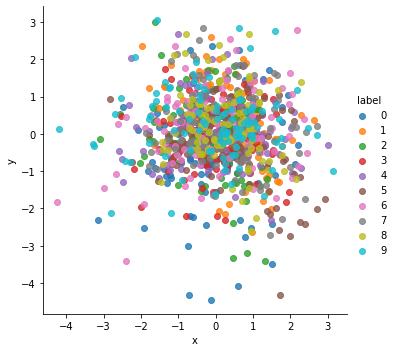

In [ ]:
main()

In [ ]:
vae = torch.load('./2022-03-08vae.mdl')

In [ ]:
torch.tensor([[1]])

tensor([[1]])

tensor([[0.1000, 1.8000]])
(1, 784)


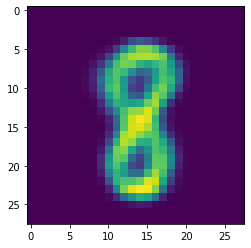

In [ ]:
#z = torch.tensor([[ 0.3813,  1.2654,  1.5641,  0.1598, -0.5343,  0.6262, -0.0164,  1.2995, 2.1619, -0.3344]])
z = torch.rand(2).unsqueeze(0)
z = torch.tensor([[0.1, 1.8]])
print(z)
sample_img = vae.decoder(z=z, c =torch.tensor([8]))


sample_img = sample_img.detach().numpy()

print(sample_img.shape)


sample_img = sample_img.reshape(28, 28)
plt.imshow(sample_img)
plt.show()

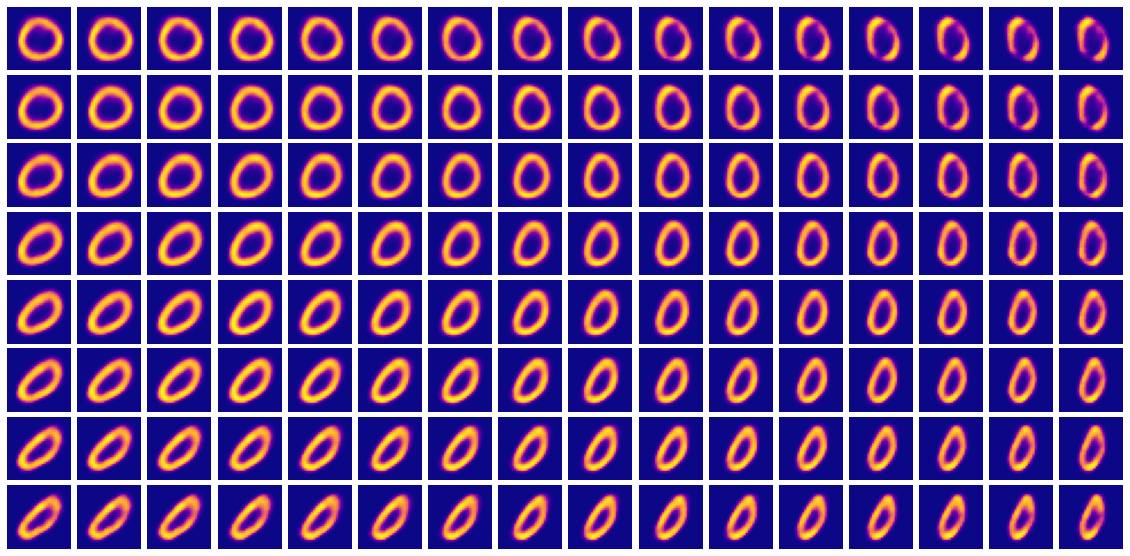

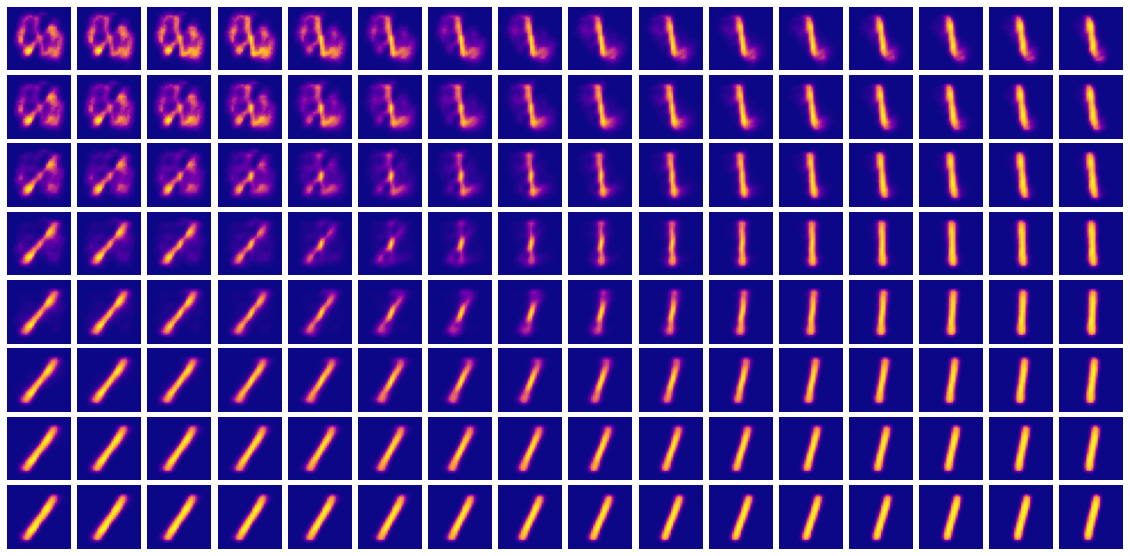

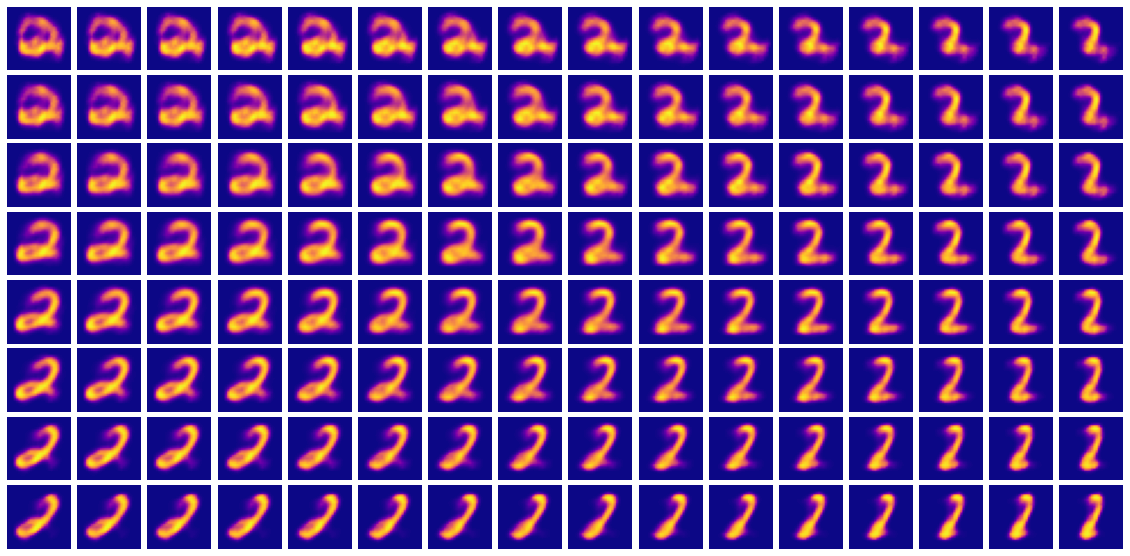

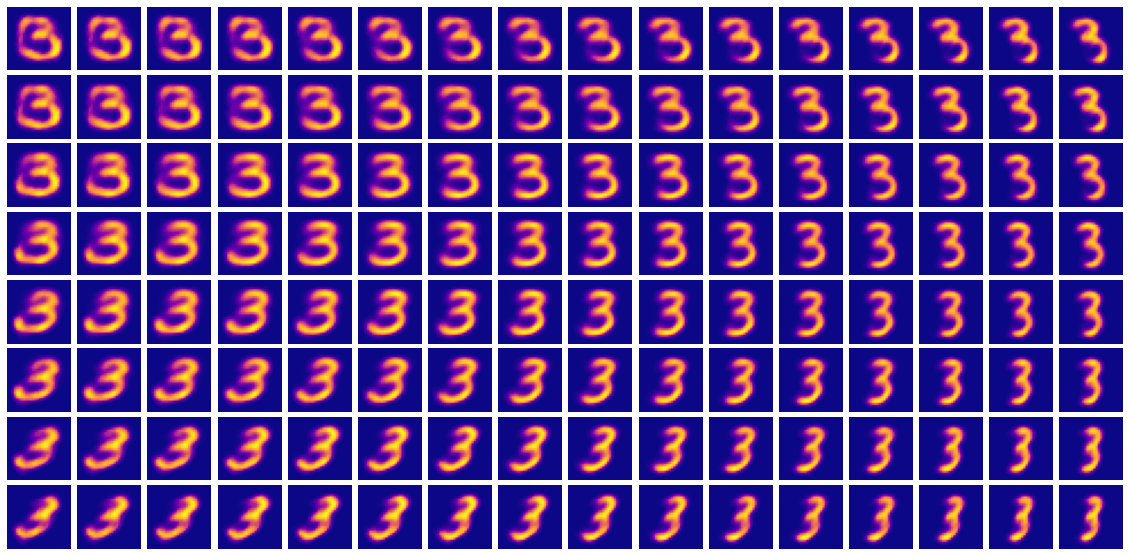

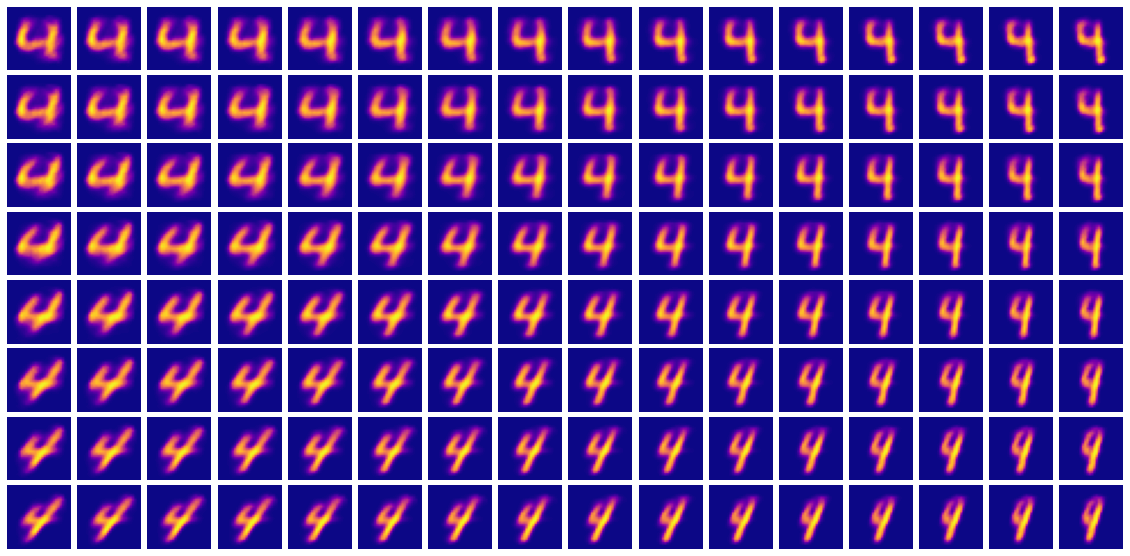

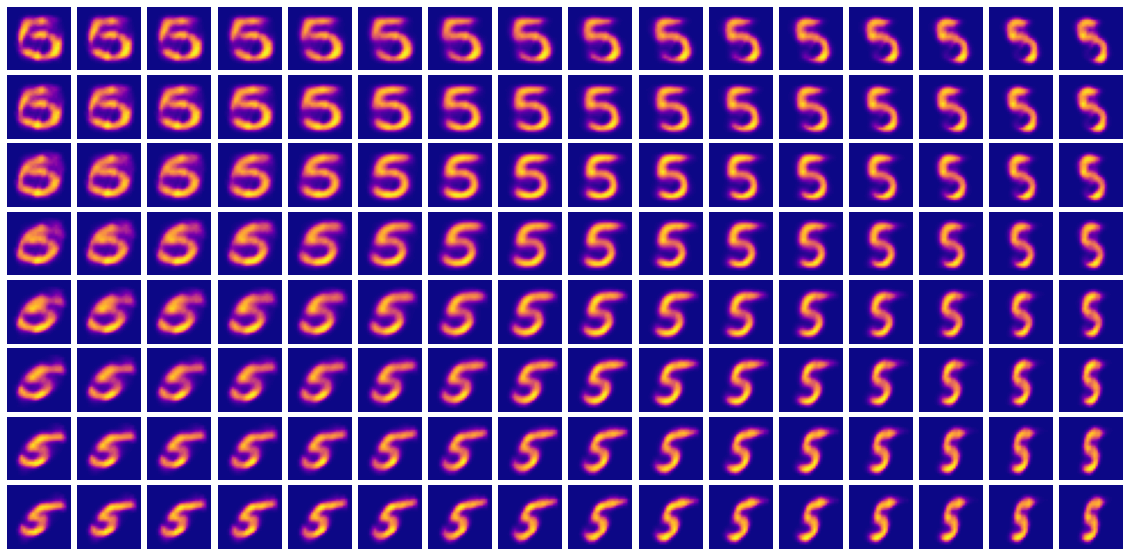

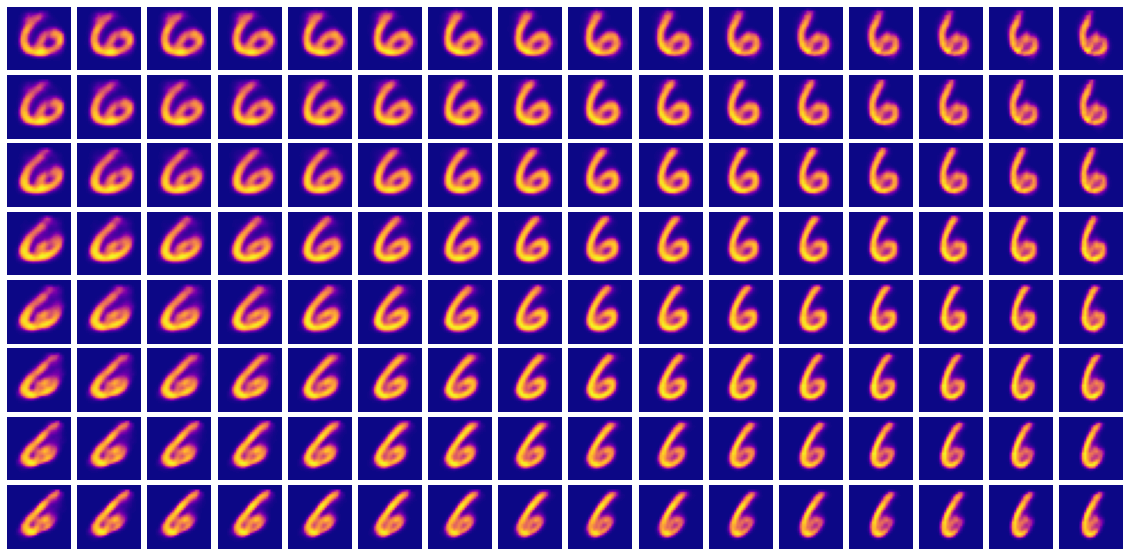

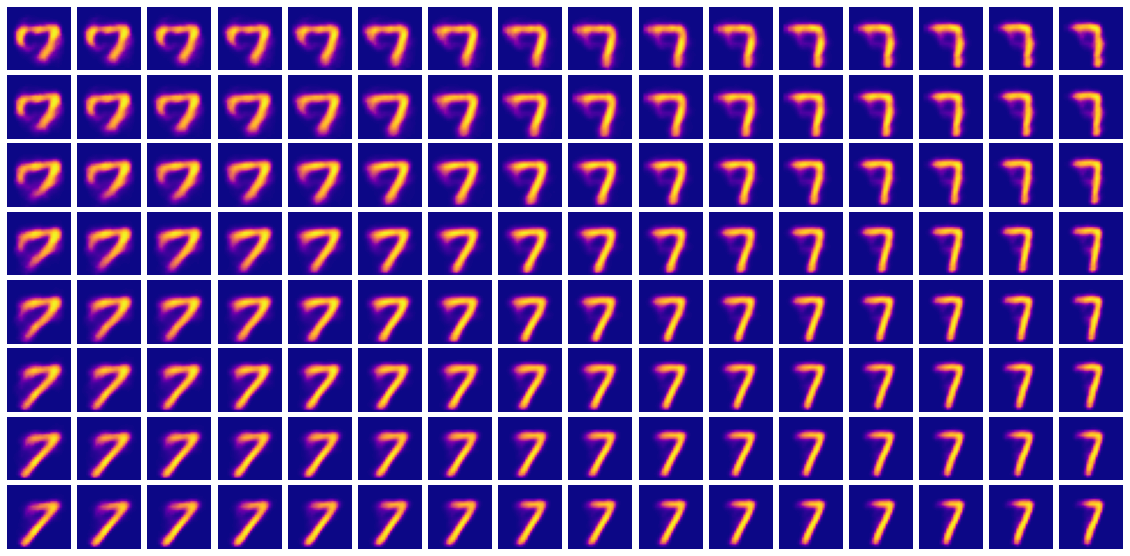

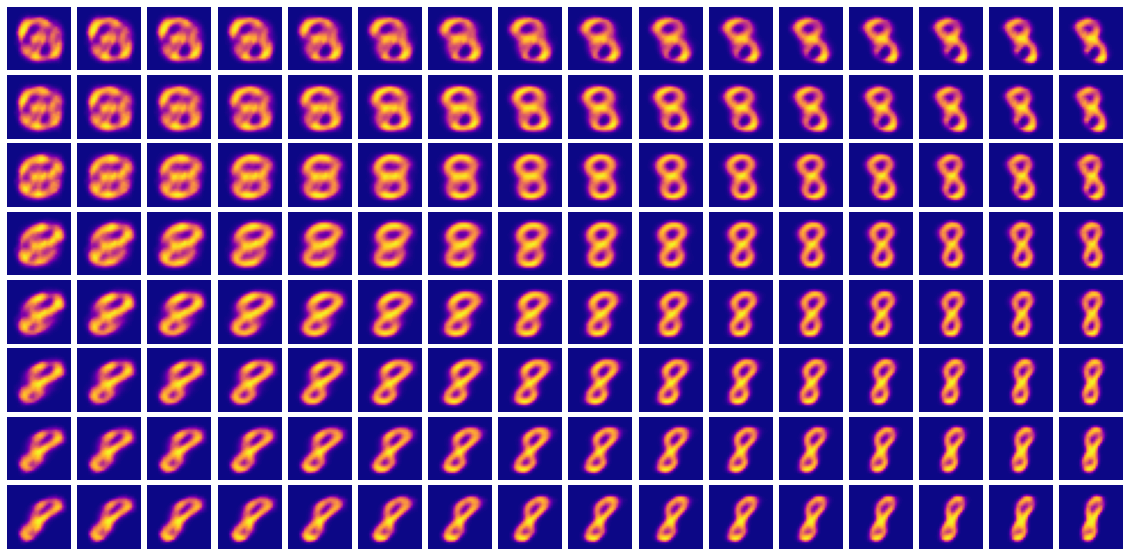

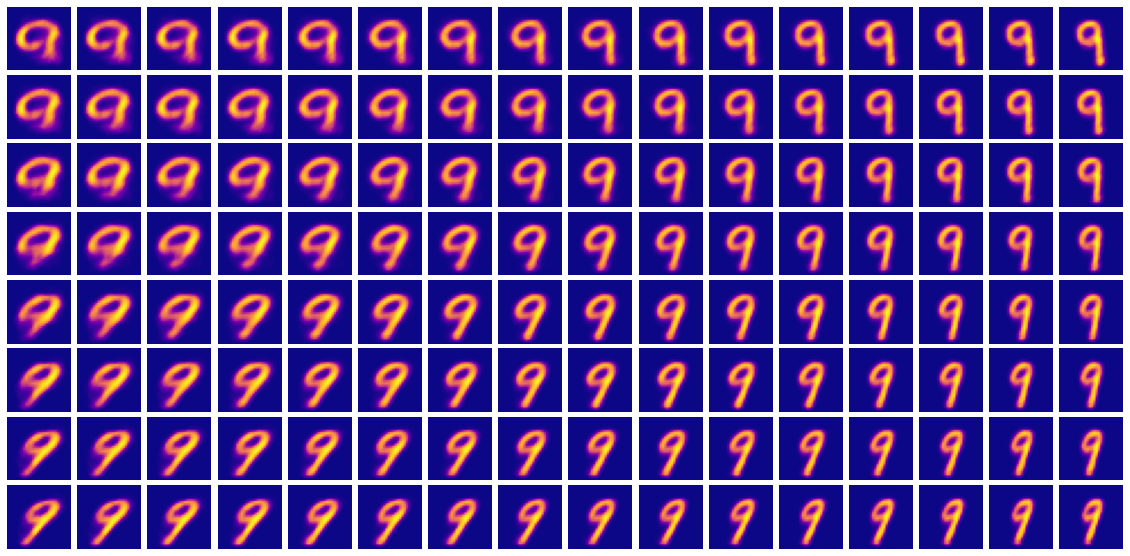

In [ ]:
import numpy as np


for idx in range(10):
    sample_map_list = []
    for x in np.linspace(-2, 2, 8):
        for y in np.linspace(-2, 2, 16):


            z = torch.tensor([[x, y]])
            #print(x, y)
            z = z.float()
            sample_img = vae.decoder(z=z, c =torch.tensor([idx]))


            sample_img = sample_img.detach().numpy()

            sample_img = sample_img.reshape(28, 28)
            sample_map_list.append(sample_img)
            # plt.imshow(sample_img)
            # plt.show()

    #print(len(sample_map_list))

    plt.figure(figsize=(20,10))
    for i in range(128):
        plt.subplot(8,128//8,i+1)
        plt.axis('Off')
        plt.subplots_adjust(wspace=0.1,hspace=0.05)
        plt.imshow(sample_map_list[i], cmap='plasma')
    #plt.suptitle("[regression] High resolution feature map (inner layer2)" + " date:"+ model_date)
    plt.savefig("./" + str(i) + "_samples.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()